In [103]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# models
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [2]:
### LOAD DATA FROM CSV INTO SQL DATABASE
DB_FILE = 'netflix.db'
# if DB file does not exist use the csv data to populate it
if not os.path.exists(DB_FILE):    
    titles = pd.read_csv('titles.csv')
    # make the database connection
    dbcon = sqlite3.connect(DB_FILE)
    # create empty tables with the correct relationships for population with the csv data
    create_titles = '''CREATE TABLE IF NOT EXISTS Titles (
                                            id TEXT PRIMARY KEY,
                                            title TEXT,
                                            type TEXT,
                                            description TEXT,
                                            release_year INTEGER,
                                            age_certification TEXT,
                                            runtime INTEGER,
                                            genres TEXT,
                                            production_countries TEXT,
                                            seasons INTEGER,
                                            imdb_id TEXT,
                                            imdb_score INTEGER,
                                            imdb_votes INTEGER,
                                            tmdb_popularity INTEGER,
                                            tmdb_score INTEGER
                                        );'''
    create_credits = '''CREATE TABLE IF NOT EXISTS Credits (
                                            person_id INTEGER NOT NULL,
                                            id TEXT NOT NULL,
                                            name TEXT NOT NULL,
                                            character TEXT,
                                            role TEXT,
                                            in_2021 INTEGER DEFAULT 0,
                                            FOREIGN KEY (id) REFERENCES title(id)
                                        );'''
    
    cur = dbcon.cursor() # create the above empty tables
    cur.execute(create_titles)
    cur.execute(create_credits)
    
    # use pandas to read the data for easy storage into the SQLite db
    titles = pd.read_csv('titles.csv')
    titles.to_sql('Titles', con=dbcon, if_exists='append', index=False)
    
    credits = pd.read_csv('credits.csv')
    credits.to_sql('Credits', con=dbcon, if_exists='append', index=False)
    dbcon.commit()
    # Create a column for weather or not this person is in 2021
    cur.execute('''
    UPDATE Credits
    SET in_2021 = 1
    WHERE Credits.person_id IN
    (
        SELECT Credits.person_id
        FROM Credits
        INNER JOIN Titles ON Titles.id = Credits.id
        WHERE Titles.release_year >= 2021
        GROUP BY Credits.person_id
    )
    ''')
    dbcon.commit()
    dbcon.close()


In [3]:
# EDA
dbcon = sqlite3.connect(DB_FILE)
cur = dbcon.cursor()

cur.execute('''
SELECT imdb_score, tmdb_score FROM Titles WHERE imdb_score NOT NULL AND tmdb_score NOT NULL
''')
cur.row_factory = lambda cursor, row: list(row)
scores = np.array(cur.fetchall()).T
#print(scores[0])
#plt.scatter(scores[0], scores[1])
print(np.cov(scores))

[[1.32556035 0.7733128 ]
 [0.7733128  1.3062808 ]]


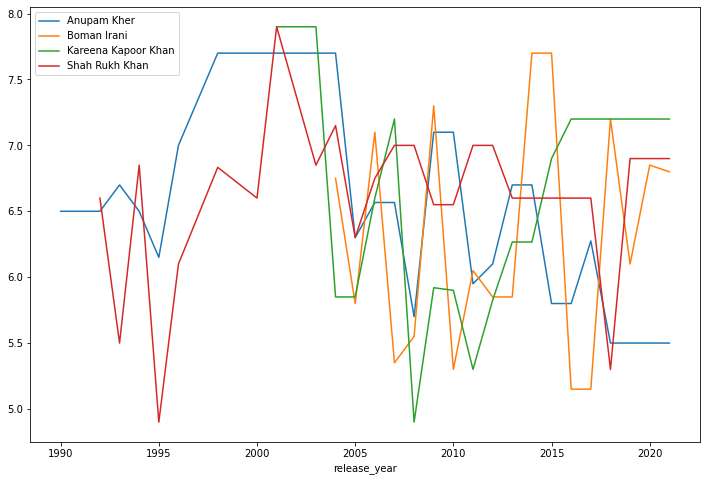

In [4]:
## MORE EDA
cur.row_factory = lambda cursor, row: list(row)

score_metric = 'tmdb_score'
star_query = '''
SELECT name, release_year, '''+score_metric+''' FROM
(
    SELECT  Credits.name, Titles.release_year, Titles.'''+score_metric+''', 
        COUNT(Credits.person_id) OVER (PARTITION BY Credits.person_id) AS freq
    FROM Credits
    INNER JOIN Titles ON Titles.id = Credits.id
    ORDER BY Titles.release_year
)
WHERE freq > 24
'''
star_scores = pd.read_sql_query(star_query, dbcon)
star_scores = star_scores.pivot_table(index='release_year', columns='name')
star_scores.columns = [col[1] for col in star_scores.columns]
star_scores.fillna(method='ffill', inplace=True)

plt.rcParams["figure.figsize"] = (12,8)
star_scores.plot(kind='line')

#
films_query = '''
SELECT  Credits.name, Titles.release_year, 
    COUNT(Credits.person_id) as score,
    COUNT(Credits.person_id) OVER (PARTITION BY Credits.person_id) AS freq
FROM Credits
INNER JOIN Titles ON Titles.id = Credits.id
GROUP BY Titles.release_year, Credits.person_id
ORDER BY score DESC
'''
#films_count = pd.read_sql_query(films_query, dbcon).dropna()

<AxesSubplot:xlabel='release_year', ylabel='AVG Score'>

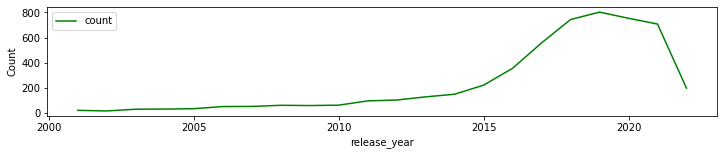

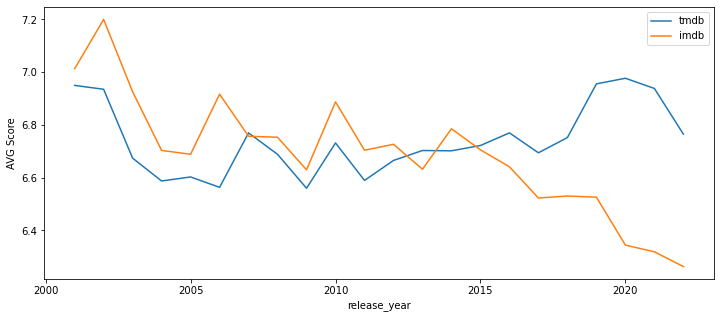

In [5]:
score_timeline = '''
SELECT release_year, count, imdb, tmdb FROM
(
    SELECT  Titles.release_year, 
        COUNT(Titles.tmdb_score) as count,
        AVG(Titles.imdb_score) as imdb,
        AVG(Titles.tmdb_score) as tmdb
    FROM Titles
    WHERE Titles.release_year > 2000
    GROUP BY Titles.release_year
    ORDER BY Titles.release_year DESC
)
'''
scores = pd.read_sql_query(score_timeline, dbcon).dropna()

plt.rcParams["figure.figsize"] = (12,2)
scores.plot(x='release_year', y=['count'], subplots=True, kind='line', ylabel='Count', color='green')

plt.rcParams["figure.figsize"] = (12,5)
scores.plot(x='release_year', y=['tmdb', 'imdb'], kind='line', ylabel='AVG Score')

In [140]:
## I decided to only to include people who appear more than twice and after 2010
## since otherwise they are not really 'up and coming'. 
# Also cannot appear in the same movie in the same year (which seems like an error)
popular_query = '''
SELECT  name, release_year, imdb_score, tmdb_score, in_2021, freq FROM
(
    SELECT  name, release_year, imdb_score, tmdb_score, in_2021, COUNT(person_id) OVER(PARTITION BY person_id) AS freq FROM
    (
        SELECT  Credits.name, Titles.release_year, Titles.imdb_score, 
            Titles.tmdb_score, Credits.in_2021, Credits.person_id
        FROM Credits
        INNER JOIN Titles ON Titles.id = Credits.id
        WHERE Titles.release_year > 2010 AND Titles.release_year < 2021 AND
            (Titles.imdb_score NOT NULL OR Titles.tmdb_score NOT NULL) AND
            Titles.production_countries LIKE '%US%'
        GROUP BY Credits.person_id, Titles.release_year, Titles.id
        ORDER BY Credits.name, Titles.release_year
    )
)
WHERE freq >= 3
'''
pop_ppl = pd.read_sql_query(popular_query, dbcon)

def score_delta(scores):
    first = scores.iloc[0]
    last = scores.iloc[-1]
    
    if pd.isna(first):
        return last - scores.mean()
    if pd.isna(last):
        return scores.mean() - first
    return last - first

#Organize data for prediction purposes
pop_ppl = pop_ppl.pivot_table(index='name',  aggfunc=
                    {'release_year': 'last',
                     'in_2021': 'first',
                     'imdb_score': [np.mean, score_delta],
                     'tmdb_score': [np.mean, score_delta],
                     'freq': 'first'}).fillna(0)

pop_ppl.columns = ['freq', 'avg_imdb', 'delta_imdb', 'in_2021', 'last_year', 'avg_tmdb', 'delta_tmdb']
pop_ppl

,freq,avg_imdb,delta_imdb,in_2021,last_year,avg_tmdb,delta_tmdb
name,,,,,,,
50 Cent,3,6.866667,0.800000,0,2020,6.700000,0.8
A.D. Miles,4,6.800000,-0.600000,0,2020,6.550000,0.9
Aaron Eckhart,4,5.675000,-1.300000,0,2016,5.800000,-1.0
Aaron Paul,4,7.733333,-0.633333,0,2019,7.400000,-0.1
Aaron Taylor-Johnson,3,6.933333,0.500000,0,2018,6.900000,0.4
...,...,...,...,...,...,...,...
Zoe Kazan,3,6.600000,0.300000,1,2019,6.466667,0.7
Zoe Saldana,3,6.966667,-1.900000,1,2020,6.566667,-1.6
Zoey Deutch,5,6.675000,1.275000,0,2020,7.200000,1.8


<AxesSubplot:>

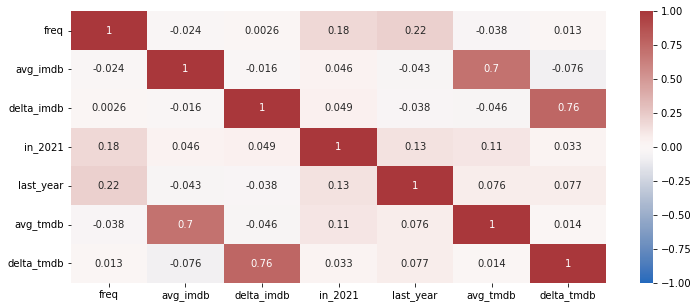

In [141]:
# normalize the inputs for logitsic regression

in_cols = ['freq', 'avg_imdb', 'delta_imdb', 'last_year', 'avg_tmdb', 'delta_tmdb']
normalized = pop_ppl.copy()
#normalized[in_cols] = (pop_ppl[in_cols]-pop_ppl[in_cols].mean())/pop_ppl[in_cols].std()
normalized[in_cols] = (pop_ppl[in_cols] - pop_ppl[in_cols].min()) / (pop_ppl[in_cols].max()-pop_ppl[in_cols].min())

corrMatrix = normalized.corr()
sns.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='vlag')

In [144]:
X = pop_ppl[['freq', 'avg_tmdb', 'last_year']]
y = pop_ppl['in_2021']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

predictor = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
print('Logistic Regression score:', predictor.score(X_test, y_test))

pop_ppl['prob'] = predictor.predict_proba(X).T[1]
pop_ppl.sort_values('prob', ascending=False)['prob'][:20]

Logistic Regression score: 0.6952789699570815


name
Jay Karas             0.861513
Marcus Raboy          0.845847
Fred Tatasciore       0.720059
Tiffany Haddish       0.701416
Fred Armisen          0.700171
Kari Wahlgren         0.689224
Keegan-Michael Key    0.679933
Natasha Lyonne        0.667647
Grey DeLisle          0.651195
Ron Funches           0.635162
Ryan Polito           0.634212
Jay Chapman           0.627647
Donald Trump          0.626403
Samuel L. Jackson     0.626378
Andrew Bachelor       0.617540
Tara Strong           0.612949
Adam Sandler          0.611364
Ashleigh Ball         0.607624
Steven Yeun           0.607310
Brian Drummond        0.592920
Name: prob, dtype: float64